In [45]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Función para cargar las imágenes y aplicar el filtro de Canny si es necesario
def cargar_imagenes_y_aplicar_filtro(directorio, filtro_canny=False):
    imagenes_data = []
    etiquetas = []
    
    # Define el mapeo de emociones a etiquetas numéricas
    emociones = {
        'NE': 0,  # Neutral
        'HA': 1,  # Happy
        'SA': 2,  # Sad
        'SU': 3,  # Surprise
        'AN': 4,  # Angry
        'DI': 5,  # Disgust
        'FE': 6   # Fear
    }

    contenido = os.listdir(directorio)
    imagenes = [nombre for nombre in contenido if nombre.endswith('.tiff')]

    # Función para aplicar el filtro de Canny
    def aplicar_filtro_canny(imagen, umbral1=120, umbral2=300):
        return cv2.Canny(imagen, umbral1, umbral2)

    # Cargar imágenes, con o sin filtro
    for nombre_imagen in imagenes:
        partes = nombre_imagen.split('.')
        codigo_emocion = partes[1][:2]  
        etiqueta = emociones.get(codigo_emocion, -1)
        etiquetas.append(etiqueta)
        
        ruta_imagen = os.path.join(directorio, nombre_imagen)
        imagen_actual = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
        imagen_actual = cv2.resize(imagen_actual, (224, 224))
        
        if filtro_canny:
            # Aplicar el filtro de Canny
            imagen_filtrada = aplicar_filtro_canny(imagen_actual)
            imagen_rgb = cv2.cvtColor(imagen_filtrada, cv2.COLOR_GRAY2RGB)  # Convertir a RGB
        else:
            imagen_rgb = cv2.cvtColor(imagen_actual, cv2.COLOR_GRAY2RGB)  # Convertir a RGB
        
        imagen_rgb = imagen_rgb / 255.0  # Normalizar
        imagenes_data.append(imagen_rgb)

    return np.array(imagenes_data), np.array(etiquetas)

# Cargar datos con y sin filtro
directorio = r'C:/Users/joshu/Downloads/JAFFE/JAFFE/jaffedbase/jaffedbase'
imagenes_con_filtro, etiquetas = cargar_imagenes_y_aplicar_filtro(directorio, filtro_canny=True)
imagenes_sin_filtro, _ = cargar_imagenes_y_aplicar_filtro(directorio, filtro_canny=False)

# Separar los datos en conjuntos de entrenamiento y validación
imagenes_train_con_filtro, imagenes_val_con_filtro, etiquetas_train, etiquetas_val = train_test_split(
    imagenes_con_filtro, etiquetas, test_size=0.2, random_state=42)

imagenes_train_sin_filtro, imagenes_val_sin_filtro, _, _ = train_test_split(
    imagenes_sin_filtro, etiquetas, test_size=0.2, random_state=42)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Aplicar Data Augmentation a las imágenes
datagen.fit(imagenes_train_con_filtro)
datagen.fit(imagenes_train_sin_filtro)

# Definir el modelo híbrido mejorado con más capas
def modelo_hibrido_mejorado():
    # Rama para imágenes con filtro
    entrada_con_filtro = Input(shape=(224, 224, 3))
    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(entrada_con_filtro)
    x1 = layers.MaxPooling2D((2, 2))(x1)
    x1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x1 = layers.MaxPooling2D((2, 2))(x1)
    x1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x1)
    x1 = layers.MaxPooling2D((2, 2))(x1)
    x1 = layers.GlobalAveragePooling2D()(x1)

    # Rama para imágenes sin filtro
    entrada_sin_filtro = Input(shape=(224, 224, 3))
    x2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(entrada_sin_filtro)
    x2 = layers.MaxPooling2D((2, 2))(x2)
    x2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x2)
    x2 = layers.MaxPooling2D((2, 2))(x2)
    x2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
    x2 = layers.MaxPooling2D((2, 2))(x2)
    x2 = layers.GlobalAveragePooling2D()(x2)

    # Fusionar las dos ramas
    fusion = layers.Concatenate()([x1, x2])

    # Capas finales comunes
    x = layers.Dense(256, activation='relu', kernel_regularizer='l2')(fusion)
    x = layers.Dropout(0.5)(x)
    salida = layers.Dense(7, activation='softmax')(x)

    # Definir el modelo final
    model = models.Model([entrada_con_filtro, entrada_sin_filtro], salida)

    # Compilar el modelo con optimizador SGD
    model.compile(optimizer=SGD(lr=0.001, momentum=0.9),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Crear el modelo híbrido mejorado
model = modelo_hibrido_mejorado()

# Entrenar el modelo con ambas entradas
history = model.fit(
    [imagenes_train_con_filtro, imagenes_train_sin_filtro], etiquetas_train,
    validation_data=([imagenes_val_con_filtro, imagenes_val_sin_filtro], etiquetas_val),
    epochs=100, batch_size=4
)

# Evaluar el modelo
model.evaluate([imagenes_val_con_filtro, imagenes_val_sin_filtro], etiquetas_val)


Epoch 1/100


NotFoundError: Graph execution error:

Detected at node 'model_14/conv2d_50/Relu' defined at (most recent call last):
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\asyncio\windows_events.py", line 321, in run_forever
      super().run_forever()
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\joshu\AppData\Local\Temp\ipykernel_20744\3966666990.py", line 123, in <module>
      history = model.fit(
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model_14/conv2d_50/Relu'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 29918224 bytes.
  Profiling failure on CUDNN engine 1: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 17148544 bytes.
  Profiling failure on CUDNN engine 0#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 0: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine 2#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 132382720 bytes.
  Profiling failure on CUDNN engine 2: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 132382720 bytes.
  Profiling failure on CUDNN engine 4#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1141669888 bytes.
  Profiling failure on CUDNN engine 4: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1141669888 bytes.
  Profiling failure on CUDNN engine 6#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 17597952 bytes.
  Profiling failure on CUDNN engine 6: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 17597952 bytes.
  Profiling failure on CUDNN engine 5#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 59113472 bytes.
  Profiling failure on CUDNN engine 5: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 59113472 bytes.
  Profiling failure on CUDNN engine 7#TC: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 364773376 bytes.
  Profiling failure on CUDNN engine 7: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 364773376 bytes.
	 [[{{node model_14/conv2d_50/Relu}}]] [Op:__inference_train_function_81141]

In [40]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define el directorio de la base de datos
directorio = r'C:/Users/joshu/Downloads/JAFFE/JAFFE/jaffedbase/jaffedbase'

# Define el mapeo de emociones a etiquetas numéricas
emociones = {
    'NE': 0,  # Neutral
    'HA': 1,  # Happy
    'SA': 2,  # Sad
    'SU': 3,  # Surprise
    'AN': 4,  # Angry
    'DI': 5,  # Disgust
    'FE': 6   # Fear
}

contenido = os.listdir(directorio)
imagenes = [nombre for nombre in contenido if nombre.endswith('.tiff')]
imagenes_data_filtradas = []
etiquetas = []

# Función para aplicar el filtro de Canny
def aplicar_filtro_canny(imagen, umbral1=120, umbral2=300):
    return cv2.Canny(imagen, umbral1, umbral2)

# Cargar imágenes, aplicar el filtro de Canny y preparar los datos
for nombre_imagen in imagenes:
    partes = nombre_imagen.split('.')
    codigo_emocion = partes[1][:2]  
    etiqueta = emociones.get(codigo_emocion, -1)
    etiquetas.append(etiqueta)
    
    ruta_imagen = os.path.join(directorio, nombre_imagen)
    imagen_actual = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
    imagen_actual = cv2.resize(imagen_actual, (224, 224))
    
    # Aplicar el filtro de Canny
    imagen_filtrada = aplicar_filtro_canny(imagen_actual, umbral1=120, umbral2=300)
    
    # Convertir la imagen a RGB para que tenga 3 canales
    imagen_rgb = cv2.cvtColor(imagen_filtrada, cv2.COLOR_GRAY2RGB)
    imagen_rgb = imagen_rgb / 255.0  # Normalizar
    
    imagenes_data_filtradas.append(imagen_rgb)

imagenes_data_filtradas = np.array(imagenes_data_filtradas)
etiquetas = np.array(etiquetas)

# Separar los datos en conjuntos de entrenamiento y validación
imagenes_train, imagenes_val, etiquetas_train, etiquetas_val = train_test_split(
    imagenes_data_filtradas, etiquetas, test_size=0.2, random_state=42
)

# Imprimir información sobre los datos procesados
print(f"Conjunto de entrenamiento: {imagenes_train.shape}")
print(f"Conjunto de validación: {imagenes_val.shape}")


Conjunto de entrenamiento: (170, 224, 224, 3)
Conjunto de validación: (43, 224, 224, 3)


In [41]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen.fit(imagenes_train)

# Definir el modelo compacto
def modelo_compacto_con_canny():
    inputs = Input(shape=(224, 224, 3))

    # Primera capa convolucional
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    # Segunda capa convolucional
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Tercera capa convolucional
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Capa densa
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # Dropout para reducir el sobreajuste

    # Capa de salida
    outputs = layers.Dense(7, activation='softmax')(x)

    # Definir el modelo
    model = models.Model(inputs, outputs)

    # Compilar el modelo
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Crear el modelo
model = modelo_compacto_con_canny()

# Entrenar el modelo
history = model.fit(datagen.flow(imagenes_train, etiquetas_train, batch_size=16),
                    validation_data=(imagenes_val, etiquetas_val),
                    epochs=50)

# Evaluar el modelo
model.evaluate(imagenes_val, etiquetas_val)


Epoch 1/50
11/11 [==============================] - 2s 113ms/step - loss: 1.9549 - accuracy: 0.1353 - val_loss: 1.9455 - val_accuracy: 0.1163
Epoch 2/50
11/11 [==============================] - 1s 103ms/step - loss: 1.9488 - accuracy: 0.1118 - val_loss: 1.9473 - val_accuracy: 0.1395
Epoch 3/50
11/11 [==============================] - 1s 108ms/step - loss: 1.9457 - accuracy: 0.2000 - val_loss: 1.9470 - val_accuracy: 0.1163
Epoch 4/50
11/11 [==============================] - 1s 102ms/step - loss: 1.9418 - accuracy: 0.1765 - val_loss: 1.9466 - val_accuracy: 0.1163
Epoch 5/50
11/11 [==============================] - 1s 107ms/step - loss: 1.9450 - accuracy: 0.1353 - val_loss: 1.9462 - val_accuracy: 0.0930
Epoch 6/50
11/11 [==============================] - 1s 102ms/step - loss: 1.9483 - accuracy: 0.1471 - val_loss: 1.9453 - val_accuracy: 0.1860
Epoch 7/50
11/11 [==============================] - 1s 103ms/step - loss: 1.9419 - accuracy: 0.1412 - val_loss: 1.9448 - val_accuracy: 0.1628
Epoch 

[1.9499990940093994, 0.11627907305955887]

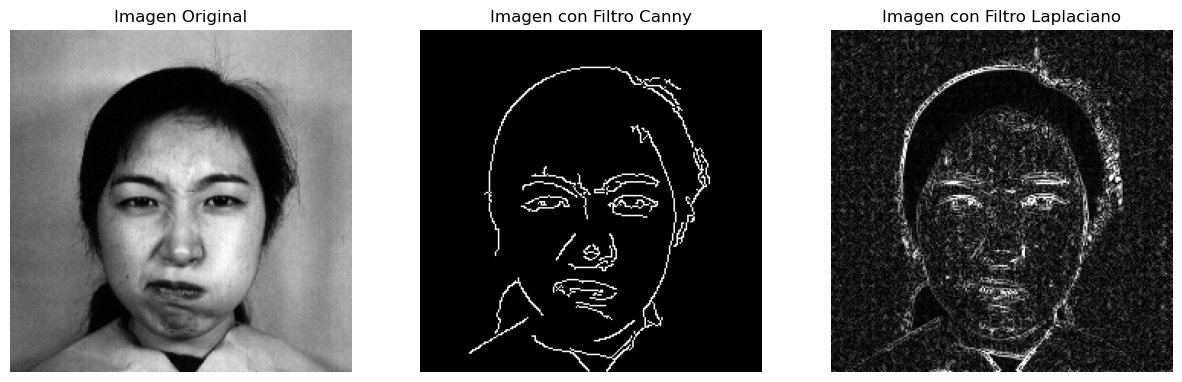

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Función para aplicar el filtro de Canny
def aplicar_filtro_canny(imagen, umbral1=120, umbral2=300):
    imagen_bordes = cv2.Canny(imagen, umbral1, umbral2)
    return imagen_bordes

# Función para aplicar el filtro Laplaciano
def aplicar_filtro_laplaciano(imagen, kernel_size=3):
    imagen_bordes = cv2.Laplacian(imagen, cv2.CV_64F, ksize=kernel_size)
    return cv2.convertScaleAbs(imagen_bordes)

# Cargar una imagen de la base de datos
ruta_imagen = os.path.join(directorio, imagenes[0])  # Seleccionar la primera imagen
imagen_original = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)

# Redimensionar la imagen a 224x224
imagen_redimensionada = cv2.resize(imagen_original, (224, 224))

# Aplicar el filtro de Canny
imagen_canny = aplicar_filtro_canny(imagen_redimensionada)

# Aplicar el filtro Laplaciano
imagen_laplaciano = aplicar_filtro_laplaciano(imagen_redimensionada)

# Mostrar las imágenes
plt.figure(figsize=(15, 5))

# Imagen original
plt.subplot(1, 3, 1)
plt.imshow(imagen_redimensionada, cmap='gray')
plt.title("Imagen Original")
plt.axis('off')

# Imagen con el filtro de Canny
plt.subplot(1, 3, 2)
plt.imshow(imagen_canny, cmap='gray')
plt.title("Imagen con Filtro Canny")
plt.axis('off')

# Imagen con el filtro Laplaciano
plt.subplot(1, 3, 3)
plt.imshow(imagen_laplaciano, cmap='gray')
plt.title("Imagen con Filtro Laplaciano")
plt.axis('off')

plt.show()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 56, 56, 64)        1849

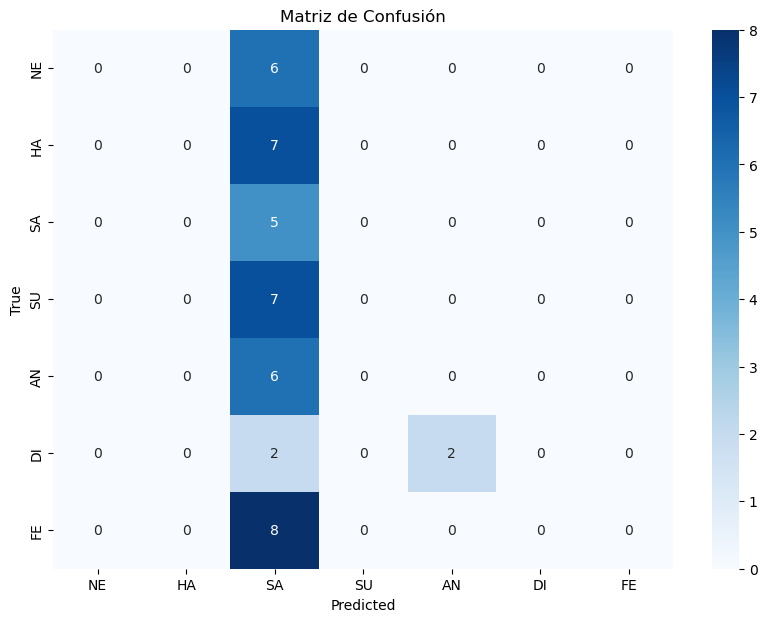

              precision    recall  f1-score   support

          NE       0.00      0.00      0.00         6
          HA       0.00      0.00      0.00         7
          SA       0.12      1.00      0.22         5
          SU       0.00      0.00      0.00         7
          AN       0.00      0.00      0.00         6
          DI       0.00      0.00      0.00         4
          FE       0.00      0.00      0.00         8

    accuracy                           0.12        43
   macro avg       0.02      0.14      0.03        43
weighted avg       0.01      0.12      0.03        43



c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\joshu\anaconda3\envs\SuperBoop\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

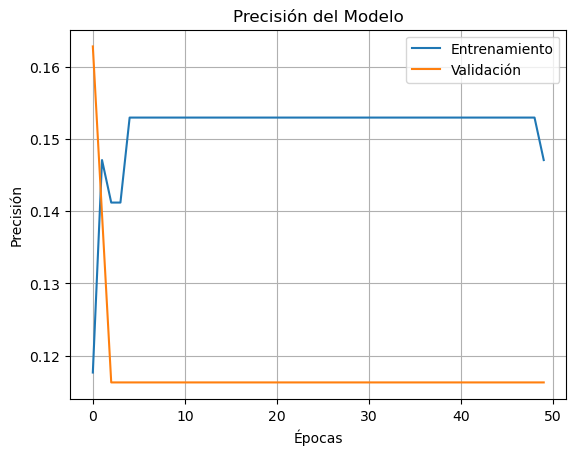

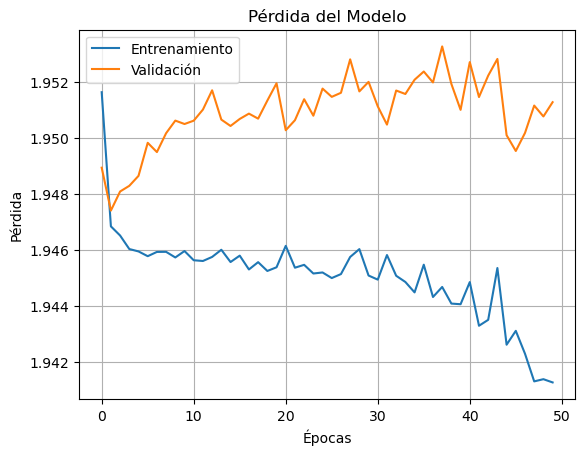

In [7]:
# Resumen del modelo
model.summary()

# Evaluar el modelo en el conjunto de validación
etiquetas_pred = np.argmax(model.predict(imagenes_val), axis=1)

# Generar la matriz de confusión
cm = confusion_matrix(etiquetas_val, etiquetas_pred)

# Visualizar la matriz de confusión
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=emociones.keys(), 
            yticklabels=emociones.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

# Mostrar el reporte de clasificación
print(classification_report(etiquetas_val, etiquetas_pred, target_names=emociones.keys()))

# Graficar los resultados de entrenamiento
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid()
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Épocas')
plt.legend(['Entrenamiento', 'Validación'])
plt.show()